In [1]:
import gymnasium as gym
import panda_gym
import numpy as np
from stable_baselines3 import SAC
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor
from stable_baselines3.common.callbacks import EvalCallback
from gymnasium.wrappers import FlattenObservation
from stable_baselines3.common.vec_env import VecEnvWrapper

In [2]:
# Custom wrapper to sanitize observations
class SafeVecEnv(VecEnvWrapper):
    def __init__(self, venv):
        super().__init__(venv)

    def reset(self):
        obs = self.venv.reset()
        return self._sanitize_obs(obs)

    def step_async(self, actions):
        self.venv.step_async(actions)

    def step_wait(self):
        obs, rewards, dones, infos = self.venv.step_wait()
        return self._sanitize_obs(obs), rewards, dones, infos

    def _sanitize_obs(self, obs):
        if isinstance(obs, dict):
            obs = np.concatenate([v.ravel() for v in obs.values()], axis=0)
            obs = obs.reshape((1, -1)).astype(np.float32)
        elif isinstance(obs, list):
            obs = np.array(obs, dtype=np.float32)
        return obs

In [3]:
# Create and wrap the training environment
env = gym.make("PandaPickAndPlaceDense-v3")
env = Monitor(env)
env = FlattenObservation(env)
env = DummyVecEnv([lambda: env])
env = VecMonitor(env)
env = SafeVecEnv(env)


# Create and wrap the evaluation environment
eval_env = gym.make("PandaPickAndPlaceDense-v3")
eval_env = Monitor(eval_env)
eval_env = FlattenObservation(eval_env)
eval_env = DummyVecEnv([lambda: eval_env])
eval_env = VecMonitor(eval_env)
eval_env = SafeVecEnv(eval_env)


# Print to verify observation shape
print("Eval env obs space:", eval_env.observation_space)
obs = eval_env.reset()
print("Sample eval obs shape:", obs.shape)


# Define evaluation callback
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path='./best_model_sac_dense/',
    log_path='./logs_sac_dense/',
    eval_freq=5000,
    deterministic=True,
    render=False)

pybullet build time: Jan 29 2025 23:16:28
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


argv[0]=--background_color_red=0.8745098114013672
argv[1]=--background_color_green=0.21176470816135406
argv[2]=--background_color_blue=0.1764705926179886
argv[0]=--background_color_red=0.8745098114013672
argv[1]=--background_color_green=0.21176470816135406
argv[2]=--background_color_blue=0.1764705926179886
Eval env obs space: Box(-10.0, 10.0, (25,), float32)
Sample eval obs shape: (1, 25)


/home/kamal/.local/lib/python3.10/site-packages/stable_baselines3/common/vec_env/vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(


In [4]:
# Create and train the model
model = SAC("MlpPolicy", env, verbose=1, tensorboard_log="./sac_panda_tensorboard_sac_dense/")
model.learn(total_timesteps=100_000, callback=eval_callback)

Using cuda device
Logging to ./sac_panda_tensorboard_sac_dense/SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -6.49    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 119      |
|    time_elapsed    | 1        |
|    total_timesteps | 200      |
| train/             |          |
|    actor_loss      | -5.86    |
|    critic_loss     | 7.57     |
|    ent_coef        | 0.971    |
|    ent_coef_loss   | -0.197   |
|    learning_rate   | 0.0003   |
|    n_updates       | 99       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -7.77    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 8        |
|    fps             | 92       |
|    time_elapsed    | 4        |
|    total_ti

In [5]:
model.save("sac_panda_pick_and_place_dense_flat")
print("Model saved.")

Model saved.


In [4]:
# Load a trained model
model = SAC.load("sac_panda_pick_and_place_dense_flat", env=env)
print("Model loaded.")

Model loaded.


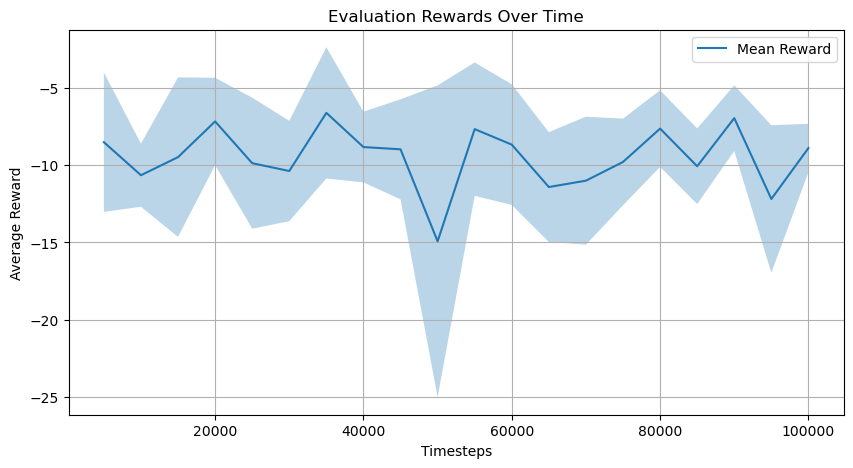

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Load evaluation results
eval_data = np.load("./logs_sac_dense/evaluations.npz")
timesteps = eval_data["timesteps"]
results = eval_data["results"]  # shape = (n_evals, n_eval_episodes)

# Compute average and std over episodes
mean_rewards = results.mean(axis=1)
std_rewards = results.std(axis=1)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(timesteps, mean_rewards, label="Mean Reward")
plt.fill_between(timesteps, mean_rewards - std_rewards, mean_rewards + std_rewards, alpha=0.3)
plt.xlabel("Timesteps")
plt.ylabel("Average Reward")
plt.title("Evaluation Rewards Over Time")
plt.grid(True)
plt.legend()
plt.show()


In [11]:
from gymnasium.wrappers import FlattenObservation
import time

# Create renderable environment with flattened observation space
env = gym.make("PandaPickAndPlaceDense-v3", render_mode="human")
env = FlattenObservation(env)

# Load model
model = SAC.load("sac_panda_pick_and_place_dense_flat", env=env)

# Run a few episodes
episodes = 300

for ep in range(episodes):
    obs, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        env.render()
        total_reward += reward
        time.sleep(0.05)  # Slow down rendering

    print(f"Episode {ep+1} - Total Reward: {total_reward}")


argv[0]=--background_color_red=0.8745098114013672
argv[1]=--background_color_green=0.21176470816135406
argv[2]=--background_color_blue=0.1764705926179886
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=5
argv[0] = --unused
argv[1] = --background_color_red=0.8745098114013672
argv[2] = --background_color_green=0.21176470816135406
argv[3] = --background_color_blue=0.1764705926179886
argv[4] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce RTX 2070 Super with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 550.120
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 550.120
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce RTX

KeyboardInterrupt: 

In [12]:
env.close()

numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed


In [10]:
import torch
print("Is CUDA available:", torch.cuda.is_available())
print("CUDA device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


Is CUDA available: False
CUDA device name: None
